In [1]:
# you can encircle with a non-circular boundary
# do so for the tuebrook boundary

In [2]:
import os

import geopandas as gpd
import pandas as pd
import numpy as np
import momepy as mm
import networkx as nx

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
from mapclassify import greedy

user = os.environ.get('DB_USERNAME')
pwd = os.environ.get('DB_PASSWORD')
host = os.environ.get('DB_HOSTNAME')
port = os.environ.get('DB_PORT')

url = f"postgres+psycopg2://{user}:{pwd}@{host}:{port}/geodemo"
engine = create_engine(url)

In [3]:
from shapely.geometry import Point, MultiLineString, MultiPolygon
from shapely.ops import split

In [4]:
def pgselect(table, buffer=900, x=338157, y=393037):
    sql = f'''
    SELECT * FROM {table} 
    WHERE ST_DWithin(geometry, ST_SetSRID(ST_Point({x}, {y}), 27700), {buffer})'''
    return gpd.read_postgis(sql, engine, geom_col='geometry')

In [5]:
def encircle(geometry, circle):
    # if geometry is polygon
    if geometry.type == 'Polygon':
        return MultiPolygon([p for p in list(split(geometry, circle.boundary)) 
                         if circle.buffer(1).contains(p)])
    if geometry.type == 'LineString':
        return MultiLineString([p for p in list(split(geometry, circle.boundary)) 
                         if circle.buffer(1).contains(p)])
    

In [6]:
rds = pgselect('openroads')
bgs = pgselect('openmaplocal')
pn = pgselect('openuprn')
rwy = pgselect('railways')
encs = pgselect('enclosures')

In [7]:
t=encs.iloc[3].geometry

In [8]:
z = t.centroid
circle = z.buffer(800)

sliced = encs.geometry.apply(lambda x: encircle(x, circle))
esliced = gpd.GeoDataFrame(geometry=sliced)
these = esliced.loc[~esliced.geometry.apply(lambda x: x.is_empty)]

these['c'] = greedy(these)

In [9]:
trds = rds.loc[rds.geometry.apply(lambda x: t.buffer(1).contains(x))]
tbgs = bgs.loc[bgs.geometry.apply(lambda x: t.contains(x))]
tpn = pn.loc[pn.geometry.apply(lambda x: t.contains(x))]

In [15]:
trds = trds.loc[trds.roadFunction!='Secondary Access Road']

In [10]:
boundary = gpd.GeoDataFrame(geometry=gpd.GeoSeries(t.boundary))

(337592.8344125576, 338752.554551783, 392242.529735775, 393808.2176316297)

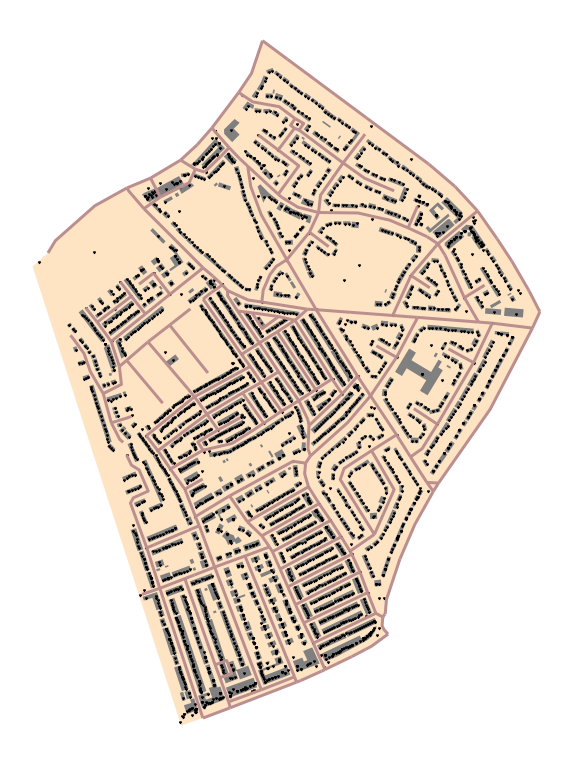

In [25]:
plt.rc('legend',fontsize=15) 
fig, ax = plt.subplots(figsize=(10,20))
these.iloc[3:4].plot(color='bisque', ax=ax)
trds.plot(ax=ax, linewidth=3, legend=True, color='rosybrown')
tbgs.plot(ax=ax, color='gray')
tpn.plot(ax=ax, color='k', markersize=10, marker='1')
# boundary.plot(color='k', linewidth=5, ax=ax)
plt.axis('off')

In [12]:
trds.roadFunction.value_counts()

Local Road                      185
A Road                           32
Restricted Local Access Road     16
Secondary Access Road            12
Name: roadFunction, dtype: int64

In [13]:
len(tpn)

3702

In [26]:
len(trds.name1.unique())

69

In [27]:
class Neighbourhood:
    def __init__(self):
        pass
    

In [28]:
## colouring face-blocks

In [34]:
def closest_road(pt_row):
    t0 = time.time()
    rd_df= trds
    # for each points row
    # get point id
    pt_it = pt_row.UPRN
    # get distance to all roads,
    dfdict = dict()
    for i in range(len(rd_df)):
        rd_row = rd_df.iloc[i]
        dfdict[i] = dict()
        dfdict[i]['rd_id'] = rd_row.id
        dfdict[i]['distance'] = pt_row.geometry.distance(rd_row.geometry)
    t1 = time.time()
    print(t1-t0)
    return pd.DataFrame(dfdict).T.sort_values('distance').iloc[0].values[0]

In [31]:
import time

In [35]:
tpn[['nearest_rd']]=tpn.apply(closest_road,axis=1)
trds['color'] = trds.index
mapper = {d[1]:d[0] for d in dict(trds.id.T).items()}
tpn['color'] = tpn.nearest_rd.apply(lambda x: mapper[x])

<AxesSubplot:>

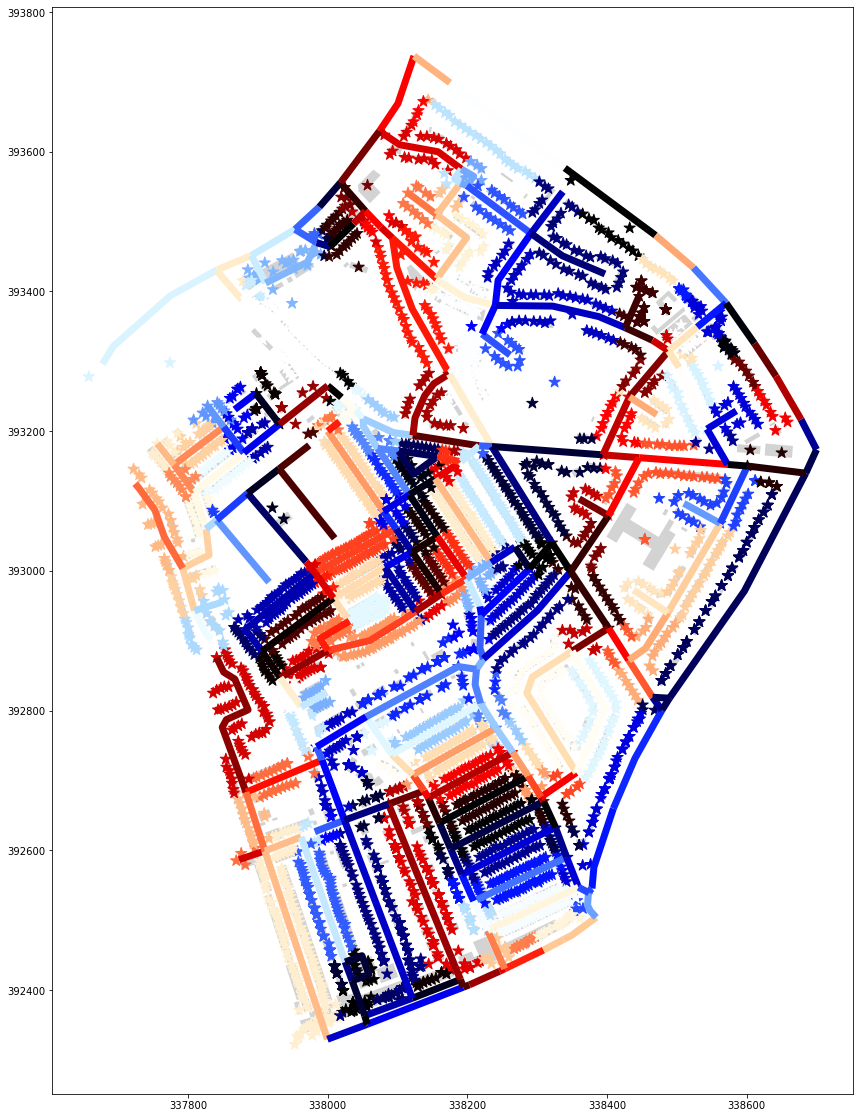

In [39]:
cmap = 'flag'
fig, ax = plt.subplots(figsize=(20,20))
trds.plot('color', ax=ax, cmap=cmap, linewidth=7)
tpn.plot('color',ax=ax, markersize=140, cmap=cmap, marker="*")
# rwys.plot(ax=ax)
tbgs.plot(ax=ax, color='lightgray')
# nodes.plot(ax=ax, color='k')
# for i, point in enumerate(tpn.geometry):
#     plt.text(point.x+2, point.y, str(i+1), color='k', fontsize=8)

In [68]:
import matplotlib.pyplot as plt

plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20c.colors)

fig, ax = plt.subplots()
for i in range(15):
    ax.plot([0,1], [i, 2*i])

plt.show()

In [71]:
set2.colors

((0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254))

In [125]:
tpn.nearest_rd

0       id26591034-E445-4B7F-80AA-E7EEBF03F2FC
1       id26591034-E445-4B7F-80AA-E7EEBF03F2FC
2       id26591034-E445-4B7F-80AA-E7EEBF03F2FC
3       id26591034-E445-4B7F-80AA-E7EEBF03F2FC
4       id5852DA83-18B0-4700-87C4-C8539FC17265
                         ...                  
8593    id3963A194-EB75-4B90-8299-3B784ECFDDDA
8598    idD41DDEB3-66E2-40F9-8987-943C41E57DCE
8599    idD41DDEB3-66E2-40F9-8987-943C41E57DCE
8601    id442F5AF9-FD44-4496-BE8F-3963FF3D2E6F
8603    id62F31328-3AEF-4782-8EFD-76D8F18DCBF7
Name: nearest_rd, Length: 3702, dtype: object

In [126]:
trds.id

17     id05F0439A-C864-4EC4-9E9F-4C4434C5097B
21     id368C3678-9B72-4E4B-A7B2-6E27ADCBFBA4
57     idCF1BDD76-9D33-4BFE-B66B-619ADA602C02
65     idE029418F-810B-41CC-BC7D-230499C94C94
67     id6B8BD4F6-14ED-4889-B232-DC7956392611
                        ...                  
485    idD5FDD93F-D476-4AE3-80A3-02FC89CBD27C
486    idBBBBCAE7-D68C-403F-AF45-F506146AF957
487    id17241C20-4C56-46D7-A29A-4745EC944A05
488    id857FBC2A-8D14-4D52-8C54-485829637A48
489    id07D38E6D-393D-47B6-A19A-5E1C7590E375
Name: id, Length: 233, dtype: object

(337592.8344125576, 338752.554551783, 392242.529735775, 393808.2176316297)

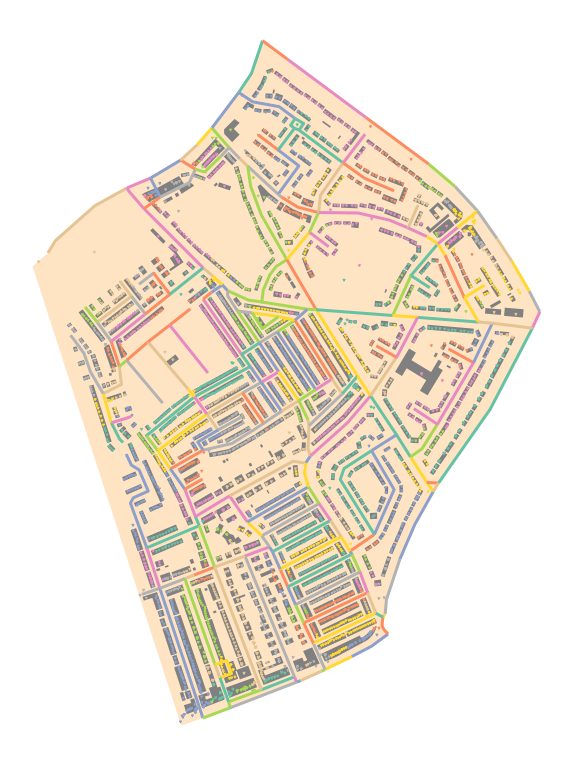

In [138]:
cmap='Set2'
plt.rc('legend',fontsize=15) 
fig, ax = plt.subplots(figsize=(10,20))
these.iloc[3:4].plot(color='bisque', ax=ax)
trds.plot('id', ax=ax, linewidth=3,cmap=cmap)#olor='grey')
tbgs.plot(ax=ax, color='gray')
tpn.plot('nearest_rd', ax=ax, cmap=cmap, markersize=10, marker='1')
# boundary.plot(color='k', linewidth=5, ax=ax)
plt.axis('off')
# trds.plot('color', ax=ax, cmap=cmap, linewidth=7)
# tpn.plot('color',ax=ax, markersize=140, cmap=cmap, marker="*")

In [156]:
tpn[['UPRN', 'nearest_rd']].to_csv('nearest_rds.csv', index=False)

In [143]:
nearest = tpn[['UPRN', 'nearest_rd']]

In [145]:
nearest

,UPRN,nearest_rd
0,38000554,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
1,38000555,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
2,38000556,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
3,38000557,id26591034-E445-4B7F-80AA-E7EEBF03F2FC
4,38000558,id5852DA83-18B0-4700-87C4-C8539FC17265
...,...,...
8593,10025739566,id3963A194-EB75-4B90-8299-3B784ECFDDDA
8598,10091806097,idD41DDEB3-66E2-40F9-8987-943C41E57DCE
8599,10091806099,idD41DDEB3-66E2-40F9-8987-943C41E57DCE
8601,10091960195,id442F5AF9-FD44-4496-BE8F-3963FF3D2E6F


In [147]:
trds.columns

Index(['id', 'endNode', 'startNode', 'roadNumberTOID', 'roadNameTOID',
       'fictitious', 'roadClassification', 'roadFunction', 'formOfWay',
       'length', 'length_uom', 'loop', 'primaryRoute', 'trunkRoad',
       'roadClassificationNumber', 'name1', 'name1_lang', 'name2',
       'name2_lang', 'roadStructure', 'geometry', 'color'],
      dtype='object')

In [149]:
len(trds.endNode.unique())

161

In [151]:
nodes = set(trds.startNode.unique()).union(set(trds.endNode.unique()))

In [155]:
len(nodes)

178